# NLP Attention model

In [86]:
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import unicodedata
import string
import re
import random
import time
import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
USE_CUDA = False

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date

In [87]:
#Set a value for <SOS> and <EOS>
SOS_token = 0
EOS_token = 1

In [88]:
#https://www.kaggle.com/eswarchandt/neural-machine-translation-with-attention-dates

fake = Faker()

# We need to seed these guys. For some reason I always use 101
Faker.seed(101)
random.seed(101)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 1

#%% pytorch dataset

# Train dataset randomly created with size 100 datas

class datesDataset(torch.utils.data.Dataset):
    def __init__(self,locale='da',inputLength=40,outputLength=12, dataSetSize=100):
        
        self.inputLength=inputLength
        self.outputLength=outputLength
        self.length=dataSetSize
        self.lan=locale
        
        self.FORMATS= ['short', # d/M/YY
           'medium', # MMM d, YYY
           'long', # MMMM dd, YYY
           'full', # EEEE, MMM dd, YYY
           'd MMM YYY', 
           'd MMMM YYY',
           'dd/MM/YYY',
           'EE d, MMM YYY',
           'EEEE d, MMMM YYY']
        

        #generate vocabularies:
        alphabet=sorted(tuple('abcdefghijklmnopqrstuvwxyzæøå'))
        numbers=sorted(tuple('0123456789'))
        symbols=['<SOS>','<EOS>',' ',',','.','/','-','<unk>', '<pad>'];
        self.humanVocab=dict(zip(symbols+numbers+alphabet,
                            list(range(len(symbols)+len(numbers)+len(alphabet)))))
        self.machineVocab =dict(zip(symbols+numbers,list(range(len(symbols)+len(numbers)))))
        self.invMachineVocab= {v: k for k, v in self.machineVocab.items()}

    def string_to_int(self,string, length, vocab):
        string = string.lower()
        

        if not len(string)+2<=length: #+2 to make room for SOS and EOS
            print(len(string),string)
            print('Length:',length)
            
            raise AssertionError()

        
        rep = list(map(lambda x: vocab.get(x, '<unk>'),string))
        rep.insert(0,vocab['<SOS>']); rep.append(vocab['<EOS>']) #add start and of sequence
        
        if len(string) < length:
            rep += [vocab['<pad>']] * (length - len(rep))
        
        return rep        
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        dt = fake.date_object()

        date = format_date(dt, format=random.choice(self.FORMATS), locale=self.lan)
        human_readable = date.lower().replace(',', '')
        machine_readable = dt.isoformat()
        pairs = []
        for i in range(len(human_readable)):
            pairs.append([human_readable,machine_readable])
        
        humanEncoded= torch.LongTensor(self.string_to_int(human_readable,self.inputLength,self.humanVocab))
        humanEncoded= torch.reshape(humanEncoded, (self.inputLength, 1))
        machineEncoded= torch.LongTensor(self.string_to_int(machine_readable,self.outputLength,self.machineVocab))
        machineEncoded= torch.reshape(machineEncoded, (self.outputLength, 1))
        return human_readable, machine_readable, humanEncoded, machineEncoded, pairs

e = datesDataset()

In [89]:
# Validation random dataset of size 20

class datesDatasetVal(torch.utils.data.Dataset):
    def __init__(self,locale='da',inputLength=40,outputLength=12, dataSetSize= 20):
        
        self.inputLength=inputLength
        self.outputLength=outputLength
        self.length=dataSetSize
        self.lan=locale
        
        self.FORMATS= ['short', # d/M/YY
           'medium', # MMM d, YYY
           'long', # MMMM dd, YYY
           'full', # EEEE, MMM dd, YYY
           'd MMM YYY', 
           'd MMMM YYY',
           'dd/MM/YYY',
           'EE d, MMM YYY',
           'EEEE d, MMMM YYY']
        

        #generate vocabularies:
        alphabet=sorted(tuple('abcdefghijklmnopqrstuvwxyzæøå'))
        numbers=sorted(tuple('0123456789'))
        symbols=['<SOS>','<EOS>',' ',',','.','/','-','<unk>', '<pad>'];
        self.humanVocab=dict(zip(symbols+numbers+alphabet,
                            list(range(len(symbols)+len(numbers)+len(alphabet)))))
        self.machineVocab =dict(zip(symbols+numbers,list(range(len(symbols)+len(numbers)))))
        self.invMachineVocab= {v: k for k, v in self.machineVocab.items()}

    def string_to_int(self,string, length, vocab):
        string = string.lower()
        

        if not len(string)+2<=length: #+2 to make room for SOS and EOS
            print(len(string),string)
            print('Length:',length)
            
            raise AssertionError()

        
        rep = list(map(lambda x: vocab.get(x, '<unk>'),string))
        rep.insert(0,vocab['<SOS>']); rep.append(vocab['<EOS>']) #add start and of sequence
        
        if len(string) < length:
            rep += [vocab['<pad>']] * (length - len(rep))
        
        return rep        
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        dt = fake.date_object()

        date = format_date(dt, format=random.choice(self.FORMATS), locale=self.lan)
        human_readable = date.lower().replace(',', '')
        machine_readable = dt.isoformat()
        pairs = []
        for i in range(len(human_readable)):
            pairs.append([human_readable,machine_readable])
        
        humanEncoded= torch.LongTensor(self.string_to_int(human_readable,self.inputLength,self.humanVocab))
        humanEncoded= torch.reshape(humanEncoded, (self.inputLength, 1))
        machineEncoded= torch.LongTensor(self.string_to_int(machine_readable,self.outputLength,self.machineVocab))
        machineEncoded= torch.reshape(machineEncoded, (self.outputLength, 1))
        return human_readable, machine_readable, humanEncoded, machineEncoded, pairs

v = datesDatasetVal()

In [90]:
# Test dataset that create a random dataset of 40

class datesDatasetTest(torch.utils.data.Dataset):
    def __init__(self,locale='da',inputLength=40,outputLength=12, dataSetSize= 40):
        
        self.inputLength=inputLength
        self.outputLength=outputLength
        self.length=dataSetSize
        self.lan=locale
        
        self.FORMATS= ['short', # d/M/YY
           'medium', # MMM d, YYY
           'long', # MMMM dd, YYY
           'full', # EEEE, MMM dd, YYY
           'd MMM YYY', 
           'd MMMM YYY',
           'dd/MM/YYY',
           'EE d, MMM YYY',
           'EEEE d, MMMM YYY']
        

        #generate vocabularies:
        alphabet=sorted(tuple('abcdefghijklmnopqrstuvwxyzæøå'))
        numbers=sorted(tuple('0123456789'))
        symbols=['<SOS>','<EOS>',' ',',','.','/','-','<unk>', '<pad>'];
        self.humanVocab=dict(zip(symbols+numbers+alphabet,
                            list(range(len(symbols)+len(numbers)+len(alphabet)))))
        self.machineVocab =dict(zip(symbols+numbers,list(range(len(symbols)+len(numbers)))))
        self.invMachineVocab= {v: k for k, v in self.machineVocab.items()}

    def string_to_int(self,string, length, vocab):
        string = string.lower()
        

        if not len(string)+2<=length: #+2 to make room for SOS and EOS
            print(len(string),string)
            print('Length:',length)
            
            raise AssertionError()

        
        rep = list(map(lambda x: vocab.get(x, '<unk>'),string))
        rep.insert(0,vocab['<SOS>']); rep.append(vocab['<EOS>']) #add start and of sequence
        
        if len(string) < length:
            rep += [vocab['<pad>']] * (length - len(rep))
        
        return rep        
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        dt = fake.date_object()

        date = format_date(dt, format=random.choice(self.FORMATS), locale=self.lan)
        human_readable = date.lower().replace(',', '')
        machine_readable = dt.isoformat()
        pairs = []
        for i in range(len(human_readable)):
            pairs.append([human_readable,machine_readable])
        
        humanEncoded= torch.LongTensor(self.string_to_int(human_readable,self.inputLength,self.humanVocab))
        humanEncoded= torch.reshape(humanEncoded, (self.inputLength, 1))
        machineEncoded= torch.LongTensor(self.string_to_int(machine_readable,self.outputLength,self.machineVocab))
        machineEncoded= torch.reshape(machineEncoded, (self.outputLength, 1))
        return human_readable, machine_readable, humanEncoded, machineEncoded, pairs

t = datesDatasetTest()

In [91]:
# Creation of the data-loader for train, validation and test

trainLoader = DataLoader(e, 
                        batch_size=batch_size, 
                        shuffle=True)

In [92]:
validationLoader = DataLoader(v, 
                        batch_size=batch_size, 
                        shuffle=True)

In [93]:
testLoader = DataLoader(t, 
                        batch_size=batch_size, 
                        shuffle=True)

In [94]:
# Encoder

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Use GRU for provide "memory"
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [95]:
# Attention model

class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size, hidden_size)


    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len))
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        m = nn.Softmax(dim=-1)
        return m(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        energy = torch.squeeze(energy) 
        hidden = torch.squeeze(hidden) 
        energy = hidden.dot(energy)
        return energy
    

In [96]:
# Attention decoder

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        self.attn = Attn(hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1)
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs applied to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) 
        context = context.squeeze(1)       
        m = nn.LogSoftmax(dim=-1)
        output = m(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

In [97]:
#  Max norm of the gradients used in clip_grad_norm_
clip = 5.0

# Train function

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    # Initializer, set gradients to zero of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 

    # Get size of input and target sentences
    input_variable= torch.squeeze(input_variable, 0)
    target_variable = torch.squeeze(target_variable, 0)
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    
    # Use the hidden state from encoder to start decoder
    decoder_hidden = encoder_hidden 
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()


    for di in range(target_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_variable[di])

        # Get most likely word index with the highest value from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]

        decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
        if USE_CUDA: decoder_input = decoder_input.cuda()

        # Stop at end of sentence
        if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    
    # Clips gradient norm of an iterable of parameters
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data / target_length

In [98]:
hidden_size = 256
n_layers = 2
dropout_p = 0.05
max_input= 50
max_output= 20

# Initialize models
encoder = EncoderRNN(max_input, hidden_size, n_layers)
decoder = AttnDecoderRNN(hidden_size, max_output, n_layers, dropout_p=dropout_p)

if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Optimizers and loss function
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [99]:
# Set up the epochs and amount of data to track
nEpochs = 200
plot_every = 1
print_every = 10

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0
plot_loss_total = 0 
accuracy=np.zeros(nEpochs +1)

In [100]:
# Function for information through training

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [101]:
for iEpoch in range(1, nEpochs + 1):
    
    #Initilize parameters for each epochs
    estimated_labels= np.empty((0,))
    true_labels= np.empty((0,))
    
    for  _, _,human_encoded, machine_encoded, _ in trainLoader:
        
        input_variable= human_encoded
        target_variable= machine_encoded
        
        # Run the train function and return the loss
        loss= train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss
        
    # Validation dataset
    
    for input_date, output_date, humanEncoded, machineEncoded, _ in validationLoader:
    
        input_date= input_date[0]
        output_date= "<SOS>" + output_date[0] + "<EOS>"
    
        output_words= evaluate(input_date, humanEncoded, machineEncoded)
        output_sentence= ''.join(output_words)
        estimated_labels= np.append(estimated_labels, output_sentence)
        true_labels= np.append(true_labels, output_date)
        
        # Keep track of the accuracy
        accuracy[iEpoch]= np.mean(estimated_labels== true_labels)     

    if iEpoch % print_every == 0:
        print_loss_avg= print_loss_total / print_every
        print_loss_total= 0
        print_summary= '%s (%d %d%%) %.4f' % (time_since(start, iEpoch / nEpochs), iEpoch, iEpoch / nEpochs * 100, print_loss_avg)
        print(print_summary)

    if iEpoch % plot_every == 0:
        plot_loss_avg= plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total= 0

4m 53s (- 92m 47s) (10 5%) 134.1585
9m 24s (- 84m 36s) (20 10%) 71.5000
14m 6s (- 79m 55s) (30 15%) 60.6364
18m 41s (- 74m 46s) (40 20%) 58.0162
23m 13s (- 69m 39s) (50 25%) 54.6321
27m 47s (- 64m 50s) (60 30%) 46.2264
32m 21s (- 60m 5s) (70 35%) 41.7049
36m 57s (- 55m 25s) (80 40%) 35.8727
41m 28s (- 50m 41s) (90 45%) 28.4836
46m 2s (- 46m 2s) (100 50%) 22.7773
50m 34s (- 41m 23s) (110 55%) 18.3813
55m 12s (- 36m 48s) (120 60%) 16.5431
59m 45s (- 32m 10s) (130 65%) 10.1987
64m 17s (- 27m 33s) (140 70%) 5.4704
68m 52s (- 22m 57s) (150 75%) 2.9075
73m 24s (- 18m 21s) (160 80%) 2.6323
77m 56s (- 13m 45s) (170 85%) 1.4176
82m 28s (- 9m 9s) (180 90%) 1.8952
86m 59s (- 4m 34s) (190 95%) 1.7680
91m 38s (- 0m 0s) (200 100%) 0.8257


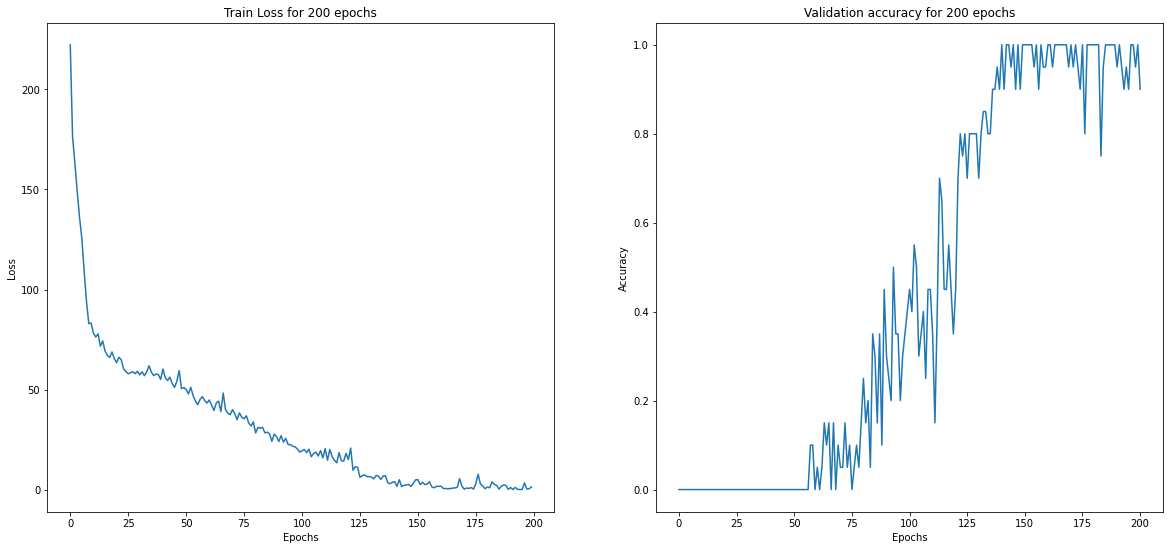

In [102]:
def train_plot(points, accuracy):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,9))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Train Loss for 200 epochs')
    ax1.plot(points)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation accuracy for 200 epochs')
    ax2.plot(accuracy)

train_plot(plot_losses, accuracy)

In [103]:
def evaluate(sentence, humanEncoded, machineEncoded, max_length= 40):
    
    # Create and adapt data for the encoder
    input_variable = humanEncoded
    input_variable= torch.squeeze(input_variable, 0)
    input_length = input_variable.size()[0]
    output_variable = machineEncoded
    output_variable= torch.squeeze(output_variable, 0)
    encoder.eval()
    decoder.eval()
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            char= e.invMachineVocab.get(ni.item())
            decoded_words.append(char)
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words

In [104]:
accuracy_test= np.zeros(40)

def evaluate_test():
    i= 0
    
    estimated_labels= np.empty((0,))
    true_labels= np.empty((0,))

    for input_date, output_date, humanEncoded, machineEncoded, _ in testLoader:
    
        input_date= input_date[0]
        output_date= "<SOS>" + output_date[0] + "<EOS>"

        output_words = evaluate(input_date, humanEncoded, machineEncoded)
        output_sentence = ''.join(output_words)
        estimated_labels= np.append(estimated_labels, output_sentence)
        true_labels= np.append(true_labels,output_date)
        
        # Keep track of the accuracy
        accuracy_test[i]= np.mean(estimated_labels== true_labels) 
        i+= 1

In [105]:
evaluate_test()

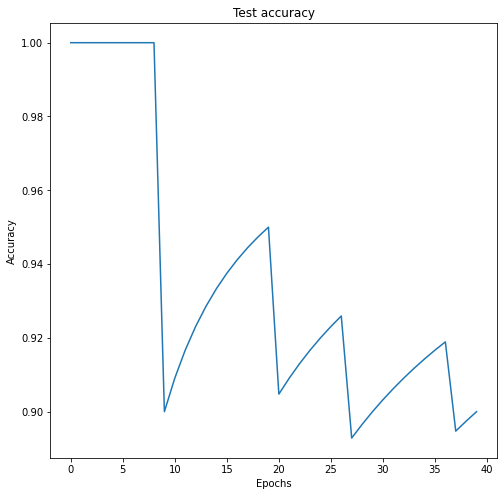

In [106]:
def test_plot(accuracy):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Test accuracy')
    ax.plot(accuracy)

test_plot(accuracy_test)

The model is optimal tuned because the valid accuracy is very similar to the test accuracy with a very high value, no overfitting neither underfitting, low bias-low variance. With a quick overview at the losses in training, the accuracy can be improved with adding some more epochs.